# Nonstationary Extremes

As with our stationary annual extremes, for the nonstationary extremes we'll be using the Generalized Extreme Value (GEV) distribution. The GEV is a family of continuous probability distributions developed to combine the Gumbel, Fréchet, and Weibull families, also known as type I, II, and III extreme value distributions, respectively. It is widely used in different fields, particularly for modeling the largest or smallest values among a large set of independent, identically distributed random values (extreme value analysis).


### Cumulative Distribution Function (CDF)

The cumulative distribution function of the GEV, which is used to calculate return periods, is given by:

\begin{align}
F(x; \mu, \sigma, \xi) = \begin{cases} 
\exp\left(-\left(1 + \xi \frac{x - \mu}{\psi}\right)^{-\frac{1}{\xi}}\right) & \text{if } \xi \neq 0, \; 1 + \xi \frac{x - \mu}{\psi} > 0 \\
\exp\left(-\exp\left(-\frac{x - \mu}{\psi}\right)\right) & \text{if } \xi = 0
\end{cases}
\end{align}

Where:
- $\mu $ (location parameter) determines the center of the distribution.
- $ \psi $ (scale parameter) is strictly positive and scales the distribution.
- $ \xi $ (shape parameter) describes the tail behavior of the distribution. It can be positive (heavy tail, Fréchet), zero (exponential tail, Gumbel), or negative (bounded tail, Weibull).

Assuming we are not dealing with a random stationary process (as with our stationary annual extremes), each parameter in the above equation can be the combination of one or more time-dependent components. These effects could include annual variability (seasonality), sea level rise (long-term trend and possible acceleration), a long-term trend for the extreme values, long-term climate variability effects explained by climate indices or the 18.61-yr nodal cycle.

The sum total of these covariates on each parameter are:
\begin{align}
\mu(t) &= \mu_{SLR}(t) + \mu_S(t)exp^{[\mu_{LT}(t)]} + \mu_N(t) + \mu_{CLI}(t),\\
\psi_t(t) &= \psi_S(t)exp^{[\psi_{LT}(t)]} + \psi_N(t) + \psi_{CLI},\\
\xi_t(t) &= \xi_S(t)exp^{[\xi_{LT}(t)]}
\end{align}

Note this includes a nonlinear component to allow for a long-term (LT) variability in the seasonality (S) in the location and scale parameters. The following codes will not include some of these terms - this is a general equation!


This example script explores the following steps:
- step1: seasonal pattern of extreme events (seasonality on location, scale, and shape parameters remain constant)
- step2: long-term trends in location parameter (linear and a possible acceleration)
- step3: Checking Covariate (ONI index) in the GEV location parameter
- step4: Checking Covariate (ONI index) in the GEV scale parameter
- step5: Checking Nodal cycle (18.6 year period, waves) in the GEV location parameter

Author: Melisa Menendez, menendezm@unican.es

Updated for Billy & Ayesha SERDP work: 09-March-2017

Updated for Python with some added explanation: July 2024

Further explanation of this code (and writeup) can be found in:
Méndez, F. J., M. Menéndez, A. Luceño, and I. J. Losada, 2007: Analyzing Monthly Extreme Sea Levels with a Time-Dependent GEV Model. J. Atmos. Oceanic Technol., 24, 894–911, https://doi.org/10.1175/JTECH2009.1.

In [1]:
import pandas as pd
import numpy as np
import scipy.io
from datetime import datetime, timedelta
from scipy.stats import chi2
from scipy.optimize import brentq
import matplotlib.pyplot as plt
import subprocess
import json

## Main Functions
Here we'll write our main functions.

### Step-wise solver
This function iteratively improves the model solution by choosing which parameters to use and evaluating if the change leads to a statistically significant improvement using a $\chi^2$ metric.

In [2]:
def stepwise(x_inisol, modelType='GEV_SeasonalMu'):
    N = len(x_inisol)


    cont = 0

    x = np.array([x_inisol]) 
    # x = x_inisol # Start with initial solution
    f, pa = fitness(x[cont], modelType)  # Compute fitness for initial solution
    f = np.array([f])
    pa = np.array([pa])
    
    better = True
    prob = 0.95
    
    while better:

        dum = np.where(x[cont] == 0)[0]  # Find positions of zeros in the chromosome
        
        if dum.size != 0:
            x_temp = np.tile(x[cont], (len(dum), 1))
            f_temp = np.zeros(len(dum))
            pa_temp = np.zeros(len(dum))
            
            for i in range(len(dum)):
                x_temp[i, dum[i]] = 1
                f_temp[i], pa_temp[i] = fitness(x_temp[i], modelType)
            best, indi = np.max(f_temp), np.argmax(f_temp)
            # Check if the improvement is significant with chi2 test
            if (best - f[cont]) >= (0.5 * chi2.ppf(prob, df=(pa_temp[indi] - pa[cont]))):
                cont += 1
                x = np.vstack((x, [x_temp[indi]]))
                f = np.vstack((f, [best]))
                pa = np.vstack((pa, [pa_temp[indi]]))
                f[cont], pa[cont] = fitness(x[cont], modelType)
            else:
                better = False
        else:
            better = False

    return x, f

### Maximum Likelihood Estimation

Since we are using monthly data, we can define our location parameter as a harmonic series to represent seasonal effects, like so:

```{margin}
```{note}
Note that some portions of the original code have a dyadic series, so while our normal series would have n going from 1 to $\infty$ we will have $n=1,2,4$, representing the annual cycle, the seasonal cycle, and the quarterly cycle. (We neglect a tri-annual cycle.)
```

$$
f(t) = A_0 + \sum_{n=1}^{\infty} \left( A_n \cos(2n \pi t) + B_n \sin(2n \pi t) \right),
$$



For example, if we can describe our location, scale and shape parameters in the GEV as:

\begin{align}
\mu(t) &= \beta_{SLR}(t) + [\beta_0 + \beta_1 cos(2\pi t) + \beta_2 sin(2\pi t) + \beta_3 cos(4\pi t) + \beta_4 sin(4\pi t)]e^{[\beta_{LT}(t)]}\\\
 &+ \beta_{N_1} cos(2\pi t/T_N) + \beta_{N_2} sin(2\pi t/T_N) + \beta_{ONI}ONI(t),\\
\psi(t) &= [\alpha_0 + \alpha_1 cos(2\pi t) + \alpha_2 sin(2\pi t)]e^{[\alpha_{LT}(t)]} \\
\xi(t) &=  [\gamma_0 + \gamma_1 cos(2\pi t) + \gamma_2 sin(2\pi t)]
\end{align}

then the vector we'd use for our MLE fit should be

$\theta = (\beta_0,\beta_1,\beta_2,\beta_3,\beta_4,\beta_{N_1},\beta_{N_2},\beta_{LT},\beta_{ONI},\alpha_0, \alpha_1, \alpha_2, \alpha_{LT},\gamma_0,\gamma_1,\gamma_2)$.

Here, $\beta_{0,1,2,3,4}$ model the seasonal variation of the location parameter, $\beta_{N1,N2}$ are the amplitudes of the nodal cycle, $\beta_{LT}$ is the long term trend of the location parameter, and $\beta_{ONI}$ is the amplitude (relative influence) of the [ONI] climate index in the location parameter. Similarly, $\alpha_{0,1,2}$ model the [cyclical] variation of the scale parameter, and $\alpha_{LT}$ models its long-term trend. For the shape parameter, only the seasonal variation is modeled ($\gamma_{0,1,2}$).

We'll use this vector $\theta$ to calculate the maximum likelihood function $L$,

$L(\theta | t_i,z_i) = \prod_{i=1}^m g[z_i;\mu(t_i),\psi(t_i),\xi(t_i)]$,

where $g$ is the PDF of the GEV (equation 1). In other words, this means that the likelihood of observing the entire dataset is the product of the likelihoods of observing each individual time point under the assumed GEV model (Maximum Likelihood Estimation, MLE).


### Parameter Search


The code below takes a varying number of parameters (a differently sized vector of regression parameters) for different models. There are three models we can run: GEV_SeasonalMu, GEV_S_T_Cv, or GEV_S_T_Cv_Nodal. Because there are so many parameters to estimate (a high-dimensional problem), a Shuffled Complex Evolution (SCE-UA,\cite{Duan}) optimization scheme is used to determine the best parameter fits. The SCE-UA is used often in hydrology, engineering, and other environmental sciences, using random clusters for initial starting points in its search algorithm and allowing them to "evolve" to a better solution. Other optimization schemes exist, but for now this is what we're using.

```{margin}
```{Note}
Still to do: get these models to run all in a python ecosystem. For right now, they will remain .exe files.
```

#### Seasonality in Location Model

Our first step is to look at seasonality only, using the GEV_SeasonalMu model, such that $\mu(t)$, $\psi(t)$, and $\xi(t)$ are:

\begin{align}
\mu(t) &=  \beta_0 + \beta_1 cos(2\pi t) + \beta_2 sin(2\pi t) + \\
&\beta_3 cos(4\pi t) + \beta_4 sin(4\pi t) + \beta_5 cos(8\pi t) + \beta_6 sin(8\pi t),\\
\psi &= \alpha_0, \\
\xi &=  \gamma_0 
\end{align}

and we'll arrange our vector of 9 regression parameters within the fitness function like so:

$\theta = [\beta_0, \alpha_0, \gamma_0, \beta_1, \beta_2, \beta_3, \beta_4, \beta_5, \beta_6].$

In this way we assume that only the location parameter changes within a year, whereas the shape and scale of the GEV distribution are constant.

#### Seasonality, Trend, and Covariate Model
For the GEV_S_T_Cv model , we'll allow a long-term trend into the location parameter and a covariate into the scale and location parameter:
```{margin}
Note this trend can be approximated as linear if our long-term trend parameter $\beta_{LT}$ is small. 

Mathmematically, as $\beta_{LT}$ goes to zero, $e^{\beta_{LT}·t}$ goes to $1 + \beta_{LT}·t$ and our expression (for the non-cyclical part of the location parameter) simplifies to $\beta_0 (1 +  \beta_{LT}·t)$. 

That is the equation of a line: $\beta_0 + \beta_0·\beta_{LT}·t$, where slope of the line is $\beta_0·\beta_{LT}$. 
```

\begin{align}
\mu(t) &= \beta_0e^{\beta_{LT}(t)}  + \beta_1 cos(2\pi t) + \beta_2 sin(2\pi t) + \beta_3 cos(4\pi t) + \beta_4 sin(4\pi t) \\
&+ \beta_5 cos(8\pi t) + \beta_6 sin(8\pi t)   + \beta_{ONI}ONI(t),\\
\psi &= \alpha_0 + \alpha_{ONI}ONI(t), \\
\xi &=  \gamma_0 
\end{align}

and we'll arrange our vector of 12 regression parameters within the fitness function like so:

$\theta = [\beta_0, \alpha_0, \gamma_0, \beta_1, \beta_2, \beta_3, \beta_4, \beta_5, \beta_6,\beta_{LT},\beta_{ONI},\alpha_{ONI}].$

#### Seasonality, Trend, Covariate and Nodal cycle Model
For the GEV_S_T_Cv_N model , we'll add in the nodal cycle:

\begin{align}
\mu(t) &= \beta_0 e^{\beta_{LT}(t)} + \beta_1 cos(2\pi t) + \beta_2 sin(2\pi t) + \beta_3 cos(4\pi t) + \beta_4 sin(4\pi t) \\
&+ \beta_5 cos(8\pi t) + \beta_6 sin(8\pi t) + \beta_{ONI}ONI(t) + \beta_{N_1} cos(2\pi t/T_N),\\
\psi &= \alpha_0 + \alpha_{ONI}ONI(t), \\
\xi &=  \gamma_0 
\end{align}

and we'll arrange our vector of 14 regression parameters within the fitness function like so:

$\theta = [\beta_0, \alpha_0, \gamma_0, \beta_1, \beta_2, \beta_3, \beta_4, \beta_5, \beta_6,\beta_{LT},\beta_{ONI},\alpha_{ONI},\beta_{N1},\beta_{N2}].$

### Input to the fitness function
Note that the input "x" to the fitness function works like a switch - if it is a parameter to include, it is 1 (True). If it is not used, it is 0 (False). It is at most 7 elements long.

- x: [1/0 1/0 1/0 1/0 1/0 1/0 1/0]
- x[0]: annual cycle, location parameter.
- x[1]: semi-annual cycle, location parameter.
- x[2]: quarterly cycle, location parameter.
- x[3]: Trend, location parameter.
- x[4]: Covariate, location parameter.
- x[5]: Covariate, scale parameter.
- x[6]: Nodal cycle, location parameter
- Max number of parameters: 14


In [3]:
def fitness(x, modelType='GEV_SeasonalMu'):
    # Load parameter limits from a file
    aux = np.loadtxt('limits.txt')
    xmax = np.zeros(len(aux))  # Initialize with NaNs
    xmin = np.zeros(len(aux))
    # Initialize parameter limits based on the chromosome
    xmin[:3] = aux[:3, 0]
    xmax[:3] = aux[:3, 1]
    cont = 3
    

    if x[0] == 1:  # Annual cycle
        xmin[cont:cont+2] = [aux[3, 0], aux[4, 0]]  # should use indices 3 and 4 (i.e., aux(4,1) and aux(5,1) in MATLAB)
        xmax[cont:cont+2] = [aux[3, 1], aux[4, 1]]
        cont += 2

    if x[1] == 1:  # Semiannual cycle
        xmin[cont:cont+2] = [aux[5, 0], aux[6, 0]]  # should use indices 5 and 6 (i.e., aux(6,1) and aux(7,1) in MATLAB)
        xmax[cont:cont+2] = [aux[5, 1], aux[6, 1]]
        cont += 2

    if x[2] == 1:  # Frequency 4w
        xmin[cont:cont+2] = [aux[5, 0], aux[6, 0]]  # should use indices 5 and 6 (same as Semiannual cycle)
        xmax[cont:cont+2] = [aux[5, 1], aux[6, 1]]
        cont += 2

    if modelType == 'GEV_S_T_Cv' or modelType == 'GEV_S_T_Cv_Nodal':
        if x[2] == 1:  # Frequency 4w, for some reason the limits change, so we'll replace them
            cont -= 2
            xmin[cont:cont+2] = [aux[7, 0], aux[8, 0]]  # 
            xmax[cont:cont+2] = [aux[7, 1], aux[8, 1]]
            cont += 2
        
        if x[3] == 1: # Trend in location parameter, beta_LT
            xmin[cont] = aux[9, 0]
            xmax[cont] = aux[9, 1]
            cont += 1
        
        if x[4] == 1: # Covariate in location parameter, beta_CV
            xmin[cont] = aux[10, 0]
            xmax[cont] = aux[10, 1]
            cont += 1

        if x[5] == 1: # Covariate in scale parameter, gamma_CV
            xmin[cont] = aux[11, 0]
            xmax[cont] = aux[11, 1]
            cont += 1
    
    if modelType == 'GEV_S_T_Cv_Nodal':
        if x[6] == 1: # Nodal component in location, beta_N1, beta_N2
            xmin[cont:cont+2] = [aux[12, 0], aux[13, 0]]
            xmax[cont:cont+2] = [aux[12, 1], aux[13, 1]]
            cont += 2


    xmin = xmin[:cont]
    xmax = xmax[:cont]

    # Prepare the initial values and parameter configuration file
    n = len(xmin)
    xini = np.zeros(n) + 0.001
    xini[2] = -0.001  # Specific initialization for third parameter
    
    # Prepare parameters for the external executable
    maxn = -2000 + 1500 * n #number of iterations
    kstop = 3 #number of iterations without improvement allowed
    pcento = 0.001
    ngs = np.ceil(n / 4)
    iseed = 955
    ideflt = 1
    npg = 2 * n + 1
    nps = n + 1
    nspl = 2 * n + 1
    mings = ngs
    iniflg = 1
    iprint = 0
    

    with open('scein.dat', 'w') as f:
        # Writing header with specified formatting
        f.write(f"{maxn:5g} {kstop:5g} {pcento:5.3g} {ngs:5g} {iseed:5g} {ideflt:5g}\n")
        f.write(f"{npg:5g} {nps:5g} {nspl:5g} {mings:5g} {iniflg:5g} {iprint:5g}\n")

        # Write chromosome values with better control over formatting
        x_formatted = " ".join(f"{int(value):1.0f}" for value in x[:-1]) + f" {int(x[-1]):1.0f}\n"
        f.write(x_formatted)

        # Writing parameter limits and initial guesses with specified precision
        for i in range(len(xini)):
            f.write(f"{xini[i]:15.8f} {xmin[i]:15.8f} {xmax[i]:15.8f}\n")        

    
    # Run the external model executable
    modelName = 'Model_' + modelType + '.exe'
    subprocess.run([modelName], check=True)
    
    # Read the output
    with open('best.txt', 'r') as file:
        bestf = float(file.readline().strip())
    
    return bestf, n

### Plot: Seasonality Effect on Extremes
Next we'll make an example plot of the seasonality effect on extremes. For each year day, we'll evaluate the CDF of the GEV at a return period of 50 years to get the the return levels within the year.

In [4]:
def plottingExtremeSeasonality(T0, seaLevel, w, ReturnPeriod=50, SampleRate=12):
    dx = 0.001
    t2 = np.arange(0, 1.101, dx)
    
    # Define the mu using the harmonic series
    mu = (w[0] + w[3] * np.cos(2 * np.pi * t2) + w[4] * np.sin(2 * np.pi * t2) +
          w[5] * np.cos(4 * np.pi * t2) + w[6] * np.sin(4 * np.pi * t2) +
          w[7] * np.cos(8 * np.pi * t2) + w[8] * np.sin(8 * np.pi * t2))
    psi = w[1]
    xi = w[2]
    
    # Define the time within the year
    twinthinyear =T0-np.floor(T0)
    
    T = T0
    R = ReturnPeriod
    S = SampleRate

    # get seaLevelS for all ReturnPeriods
    # preallocate seaLevelS with Nans for each ReturnPeriod
    seaLevelS = np.zeros((len(R), len(t2)))
    
    for i in range(len(R)):
        prob = 1 - (1 / (R[i]*S)) ### ALTERED FROM MATLAB CODE!!! ###
        seaLevelS[i,:] = mu - (psi/xi) * (1 - (-np.log(prob)) ** (-xi))
    
    
    serieCV = np.ones(len(T))
    
    # Find the root of the Quantilentime function
    def Quantilentime(x, R):
        t00, t11 = 0.00001, 1.00001  # Define the time bounds if not globally available

        # Variables previously defined as global in MATLAB code, handled here locally
        b0, b1, b2, b3, b4, b5, b6 = w[0], w[3], w[4], w[5], w[6], w[7], w[8]
        a0, bLT, bCI, aCI, bN1, bN2 = w[1], 0, 0, 0, 0, 0
        km = 12
        dt = 0.001
        ti = np.arange(t00, t11, dt)

        # Interpolate serieCV at ti points
        serieCV2 = np.interp(ti, T, serieCV)
        # Replace NaNs with zero (np.interp does this by default if outside the bounds)
        serieCV2[np.isnan(serieCV2)] = 0

        # Define mut (location(t)) and other parameters
        mut = (b0 * np.exp(bLT * ti) +
               b1 * np.cos(2 * np.pi * ti) + b2 * np.sin(2 * np.pi * ti) +
               b3 * np.cos(4 * np.pi * ti) + b4 * np.sin(4 * np.pi * ti) +
               b5 * np.cos(8 * np.pi * ti) + b6 * np.sin(8 * np.pi * ti) +
               bN1 * np.cos((2 * np.pi / 18.61) * ti) + bN2 * np.sin((2 * np.pi / 18.61) * ti) +
               (bCI * serieCV2))

        psi = a0 + (aCI * serieCV2)
        xit = xi

        # Calculate factor, equation 10 in Menendez and Woodworth (2009)
        factor = 0
        for i in range(len(ti)):
            h = np.maximum(1 + (xit * (x - mut[i]) / psi[i]), 0.0001) ** (-1 / xit)
            factor += h

        Pr = 1 - (1 / R)
        
        y = -Pr + np.exp(-km * factor * dt)

        return y
    
    YY = np.zeros(len(R))  # Preallocate for storing results
    
    for i, R in enumerate(ReturnPeriod):
        x0 = w[0]
        YY[i] = brentq(Quantilentime, x0-5, x0+5, args=(R,))  # using bracketing to find the root of Quantilentime function instead of fsolve
    
   # Start plotting
    fig, sss = plt.subplots(figsize=(10, 5))

    cmap = sns.color_palette()

    
    
    for i, R in enumerate(ReturnPeriod):
        sss.plot(t2, seaLevelS[i, :] - STNDtoMHHW, '-.', linewidth=2, color=cmap[i])
        sss.plot(t2, np.ones(len(t2)) * YY[i] - STNDtoMHHW, linewidth=2, color=cmap[i], label=f'R={R} years')
    sss.plot(twinthinyear, seaLevel-STNDtoMHHW, '+k', markersize=5, label='Monthly maxima',alpha=1)
    sss.grid(True,alpha=0.5)

    # arrange yaxis for breathing room
    meanmaxSL = np.nanmean(seaLevel-STNDtoMHHW)
    rangemaxSL = np.nanmax(seaLevel) - np.nanmin(seaLevel) # Range

    plt.axis([0, 1.001, meanmaxSL-rangemaxSL, meanmaxSL+rangemaxSL])
    plt.xticks(np.arange(0.08333/2, 1, 1/6), ['Jan', 'Mar', 'May', 'Jul', 'Sep', 'Nov'])
    
    # add legend
    fig.legend(loc='lower center', fontsize=11, ncol = 3, bbox_to_anchor=(0.5, -0.1))

    
    plt.ylabel('Sea level (m, MHHW)')
    plt.tight_layout()

    return fig, cmap

## Format data input to the model
Now we'll take our sea level data, extract the monthly maxima from our timeseries, and format it for input into the model. We need the yearday of each monthly maximum, and if using a covariate model (e.g. SOI, ENSO, wave height), the yearday of that index.

In [5]:
from pathlib import Path
import xarray as xr
%run ../setup.ipynb
%run ../plotting_functions.ipynb

data_dir = Path('../../data' )
output_dir = Path('../../output/extremes') 
input_dir = Path('./model_input')
model_output_dir = Path(data_dir,'GEV_model_output')
rsl_hourly = xr.open_dataset(data_dir/ 'rsl_hawaii.nc')

# remove stations 547,548, 14
rsl_hourly = rsl_hourly.sel(record_id=~rsl_hourly.record_id.isin([547,548,14]))

# close the file
rsl_hourly.close()


runWithoutModel = True

# check if output directory exists, if not create it
if not output_dir.exists():
    output_dir.mkdir(parents=True)

# check if model output directory exists, if not create it
if not model_output_dir.exists():
    model_output_dir.mkdir(parents=True)

# make sub-directories for each station in rsl_hourly in model_output_dir
for rid in rsl_hourly.record_id:
    ridString = str(rid.values)
    # maybe needs some leading zeros, for now we'll leave it.
    station_dir = model_output_dir / ridString
    if not station_dir.exists():
        station_dir.mkdir(parents=True)

# remove best.txt, T.txt, CI.txt, Y.txt, mio.txt, scein.dat, and sceout.dat from working directory
for file in ['best.txt', 'T.txt', 'CI.txt', 'Y.txt', 'mio.txt', 'scein.dat', 'sceout.dat']:
    if (Path(file)).exists():
        (Path(file)).unlink()



### Adjust data for storm year
```{caution}
Commenting this out for now. Do we want to use storm year?
```

In [6]:
# # add storm_time to the dataset

# storm_time = pd.to_datetime(rsl_hourly['time'].values).to_series() + pd.DateOffset(months=-4)

# storm_time_da = xr.DataArray(storm_time.values, dims=rsl_hourly['time'].dims, coords=rsl_hourly['time'].coords)

# # Add 'storm_time' as a coordinate to the dataset
# rsl_hourly = rsl_hourly.assign_coords(storm_time=storm_time_da)

# # Make 'storm_time' a dimension
# rsl_hourly = rsl_hourly.swap_dims({'time': 'storm_time'})

# # Sort by 'storm_time' to ensure monotonic order
# rsl_hourly = rsl_hourly.sortby('storm_time')

# rsl_hourly


Let's print the station names that correspond to order of the data, because I keep forgetting.

In [7]:
print(rsl_hourly.station_name.values)

['Midway' 'Johnston' 'Honolulu, Hawaii' 'Nawiliwili' 'Kahului'
 'Hilo, Hawaii' 'Mokuoloe' 'Kawaihae']


The following function reads in the hourly timeseries for a given station (rid = record id) from the rsl_hourly dataset. It returns a dataframe of monthly max sea level values (in STND datum), and time in decimal years, such that the first year of the record starts at 0, and each subsequent time step is fraction of that year.


```{margin}
TO DO: Adjust monthly maxima timeseries such that high water levels from the same event are not doubly counted.
```

In [8]:
def get_monthly_max_time_series(rid,rsl_hourly):
    station_name = rsl_hourly.station_name[rid].item()

    STNDtoMHHW = 0.001*rsl_hourly['MHHW'][rid].values

    sea_level_series = 0.001*rsl_hourly['sea_level'][rid]

    #get only data from 1993 to 2023
    sea_level_series = sea_level_series.sel(time=slice('1993', '2023'))

    # remove nans
    sea_level_series = sea_level_series.dropna('time')

    # Step 1: extract the monthly maxima
    monthly_max = sea_level_series.resample(time='1ME').max()

    # get exact time of the monthly maxima
    t_monthly_max = sea_level_series.resample(time='1ME').map(lambda x: x.time[x.argmax()])

    # To ensure it's in datetime format and to access datetime properties
    t_monthly_max['time'] = pd.to_datetime(t_monthly_max.values)

    # Now extract the day of the year (using fractional days)
    t_yearDay = t_monthly_max['time'].dt.dayofyear + t_monthly_max['time'].dt.hour/24 + t_monthly_max['time'].dt.minute/1440 + t_monthly_max['time'].dt.second/86400

    # get year of t_monthly_max
    t_year = t_monthly_max['time'].dt.year
    year0 = t_year[0].item()

    # convert t_yearDay and monthly_max to float
    t_yearDay = np.array(t_yearDay)
    monthly_max = np.array(monthly_max)
    t_monthly_max = np.array(t_monthly_max)
    t_year = np.array(t_year)

    # get decimal year such that t = year_monthly_max + t_yearDay/366
    t = (t_year-t_year[0]) + t_yearDay/366

    # save t and monthly_max to data frame
    df = pd.DataFrame({'t': t, 'monthly_max': monthly_max, 't_monthly_max': t_monthly_max})

    df = df.dropna()

    return df, STNDtoMHHW, station_name, year0




#### Prepare the covariate data timeseries.
In this case, we'll be using the ONI data we downloaded earlier in the datawrangling notebook. We'll also reindex everything to storm year (May-April).

In [9]:
def get_covariate(t_monthly_max, data_dir):
    ONI_df = pd.read_csv(data_dir / 'ONI.csv', parse_dates=['Date'])

    # drop last 2 columns
    ONI_df = ONI_df.drop(ONI_df.columns[-2:], axis=1)

    # Set the Date as the index for easier slicing and access
    ONI_df.set_index('Date', inplace=True)

    # Reindex to include all necessary dates from t_monthly_max for interpolation
    all_dates = ONI_df.index.union(t_monthly_max)

    # Reindex the DataFrame with the union of dates
    ONI_df = ONI_df.reindex(all_dates)

    # Now interpolate 
    ONI_interp_df = ONI_df.interpolate()

    # retrieve the ONI value for the monthly maxima
    ONI_interp = ONI_interp_df.loc[t_monthly_max]

    # Save ONI_interp as 'covariate' as a 1D numpy array
    covariate = ONI_interp.squeeze().to_numpy()

    return covariate

In [10]:
for rid in range(len(rsl_hourly.station_name)):
    df, STNDtoMHHW, station_name,year0 = get_monthly_max_time_series(rid,rsl_hourly)

    # add covariate to the data frame
    covariate = get_covariate(df['t_monthly_max'], data_dir)
    df['ONI'] = covariate
    # save the data frame to a csv file with station record_id
    savename = 'monthly_max_' + str(rsl_hourly.record_id[rid].values) + '.csv'
    
    savepath = input_dir / savename
    df.to_csv(savepath, index=False)

In [11]:
ii = 2
mm, STNDtoMHHW, station_name, year0 = get_monthly_max_time_series(ii,rsl_hourly)
covariate = get_covariate(mm['t_monthly_max'], data_dir)
glue("station_name", station_name)
ridString = str(rsl_hourly.record_id[ii].values)

savename = 'monthly_max_' + str(rsl_hourly.record_id[ii].values) + '.csv'
savepath = input_dir / savename

# write the data in the csv to text file for model input

mm = pd.read_csv(savepath)
mm
mm['t'].to_csv('T.txt', header=False, index=False)
mm['monthly_max'].to_csv('Y.txt', header=False, index=False)
mm['ONI'].to_csv('CI.txt', header=False, index=False)

# Close rsl_hourly
rsl_hourly.close()





'Honolulu, Hawaii'

In [12]:
STNDtoMHHW

1.722

## First look: Modeling Seasonality
Here we'll look at seasonality in the location parameter only.

In [13]:
# Initial chromosome setup
x_0 = np.array([0,0,0])

if os.path.exists(model_output_dir / ridString / 'seasonal_params.json') and runWithoutModel:
    with open(model_output_dir / ridString / 'seasonal_params.json', 'r') as f:
        output = json.load(f)
        w_s = np.array(output['w'])
        x_s = np.array(output['x'])
        mio = np.array(output['mio'])
        standard_error = np.array(output['standard_error'])
else:
    x_s, f = stepwise(x_0, modelType='GEV_SeasonalMu')
    x, f = fitness(x_s[-1],modelType='GEV_SeasonalMu')
    w_s = np.loadtxt('best.txt', dtype=float)
    mio = np.loadtxt('mio.txt',dtype=float)
    x_s = x_s[-1]

    # Assess standard errors of the parameters
    if np.linalg.det(mio) != 0:
        J = np.linalg.inv(mio)
        standard_error = np.sqrt(np.diag(J))
    else:
        standard_error = np.full(len(w_s), np.nan)


output = {'w': w_s.tolist(), 'mio': mio.tolist(), 'standard_error': standard_error.tolist(), 'x': x_s.tolist()}
savepath = os.path.join(model_output_dir,ridString, 'seasonal_params.json')
with open(savepath, 'w') as f:
    json.dump(output, f)

    

In [14]:
def adjust_w_for_plotting(x, w):
    """
    Adjusts the w array based on the x conditions and returns an array with 14 elements.

    Parameters:
        x (list): A list representing the conditions that influence the adjustment of w.
        w (array-like): An array of values to be adjusted based on x.

    Returns:
        np.ndarray: A 14-element array with adjusted values.
    """
    # Initialize the output array with 14 elements set to zero
    w_s_plot = np.zeros(14)

    # Ensure icromo is 7 elements long
    icromo = np.array(x)
    if len(icromo) != 7:
        # Fill the rest with zeros
        icromo = np.append(icromo, np.zeros(7 - len(icromo)))

    # Always present terms (mu, psi, xi)
    w_s_plot[:3] = w[1:4]
    
    # Initialize the index for the input w
    idx = 4

    # Assign terms based on icromo conditions
    if icromo[0] == 1: # annual
        w_s_plot[3:5] = w[idx:idx+2]
        idx += 2
        
    if icromo[1] == 1: # semiannual
        w_s_plot[5:7] = w[idx:idx+2]
        idx += 2

    if icromo[2] == 1: #triannual
        w_s_plot[7:9] = w[idx:idx+2]
        idx += 2

    if icromo[3] == 1: # long-term trend
        w_s_plot[9] = w[idx]
        idx += 1

    if icromo[4] == 1: # covariate, location
        w_s_plot[10] = w[idx]
        idx += 1

    if icromo[5] == 1: #covariate, scale
        w_s_plot[11] = w[idx]
        idx += 1

    if icromo[6] == 1: #nodal
        w_s_plot[12:14] = w[idx:idx+2]
        idx += 2

    # Return the adjusted array with 14 elements
    return w_s_plot


In [15]:
w_s_plot = adjust_w_for_plotting(x_s,w_s)

### Extract a timeseries of the time-dependent return values
For each time in a timeseries, we'll evaluate the CDF of the time-dependent GEV at a given return period to get the expected return level. This first function evaluates the extreme value prediction over time for a given return period.

In [16]:
def Quantilentime(x0, w, x, t00, t11, return_period, T, serieCV):
    """
    Python equivalent of the Menendez MATLAB Quantilentime function.

    Parameters:
    x0 : float
        The variable to find the root of.
    w : np.ndarray
        The current estimates of the parameters.
    x : np.ndarray
        Binary switches that indicate which parameters are active.
    t00 : float
        Start time.
    t11 : float
        End time.
    return_period : float
        Return period.
    ti : np.ndarray
        Time vector for climate index interpolation.
    serieCV : np.ndarray
        Climate index data to be interpolated.

    Returns:
    float
        The value of the function at x_value.
    """
    # ww = adjust_w_for_plotting(x, w)
    # Parameter unpacking
    b0, a0, xi, b1, b2, b3, b4, b5, b6 = w[:9] # basics + seasonal cycle
    bLT, bCI, aCI, bN1, bN2 = w[9:]  # Initialize optional parameters

    dt = 0.001
    ti = np.arange(t00, t11 + dt, dt)

    # Interpolate serieCV at ti points
    serieCV2 = np.interp(ti, T, serieCV)
    # Replace NaNs with zero (np.interp does this by default if outside the bounds)
    serieCV2[np.isnan(serieCV2)] = 0

    km = 12

    # Define mut and other parameters

    # location(t)
    mut = (b0 * np.exp(bLT * ti) +
           b1 * np.cos(2 * np.pi * ti) + b2 * np.sin(2 * np.pi * ti) +
           b3 * np.cos(4 * np.pi * ti) + b4 * np.sin(4 * np.pi * ti) +
           b5 * np.cos(8 * np.pi * ti) + b6 * np.sin(8 * np.pi * ti) +
           bN1 * np.cos((2 * np.pi / 18.61) * ti) + bN2 * np.sin((2 * np.pi / 18.61) * ti) +
           (bCI * serieCV2))
    
    # scale(t)
    psi = a0 + (aCI * serieCV2)

    # shape(t)
    xit = xi

    # factor = 0
    # for i in range(len(ti)):
    #     h = np.maximum(1 + (xit * (x0 - mut[i]) / psi[i]), 0.0001) ** (-1 / xit)
    #     factor += h

    # Vectorized factor calculation
    h = np.maximum(1 + (xit * (x0 - mut) / psi), 0.0001) ** (-1 / xit)
    factor = np.sum(h)    

    prob = 1 - (1 / return_period)

    y = -prob + np.exp(-km * factor * dt)

    return y

### Calculate Confidence Intervals

These next codes will calculate the derivative of the previous prediction, using finite differencing. We will get be getting the derivative for each parameter, with the goal of solving the total variance.

```{margin}
Note: Does this method assume that all parameters are independent, when doing the summation? The long-term trend introduces non-linearity, and the sine/cosine pairs are just phase and lag of the same signal. Can they be treated as independent? I'm pretty fuzzy on whether this is 'correct' or not. Do we instead want to do confidence intervals using Monte-Carlo?
```

In [17]:
def derivative_first_order(k, w, x, t00, t11, return_period, T, covariate):
    h = 0.0001  # Small perturbation
    x0_initial = w[1]  # Initial value for the root-finding function

    wbest = adjust_w_for_plotting(x, w)
    # Step 1: Calculate the baseline value with the current parameters
    baseline_func = lambda x0: Quantilentime(x0, wbest, x, t00, t11, return_period, T, covariate)
    baseline_value = brentq(baseline_func, x0_initial - 1, x0_initial + 1)

    # Perturb the k-th parameter
    perturbed_w = np.copy(w)
    perturbed_w[k] += h
    wbest_perturbed = adjust_w_for_plotting(x, perturbed_w)

    # Step 2: Calculate the function value with the perturbed parameter
    perturbed_func = lambda x0: Quantilentime(x0, wbest_perturbed, x, t00, t11, return_period, T, covariate)
    perturbed_value = brentq(perturbed_func, x0_initial - 1, x0_initial + 1)

    # Step 3: Numerical derivative
    derivative = (perturbed_value - baseline_value) / h
    
    return derivative

Now that we have the derivative function, we can use it to calculate the variance at each timestep by applying a first-order Taylor expansion, which assumes a locally linear relationship between the function and its parameters. The variance  $\sigma^2$  at each timestep can be approximated as:


$\sigma^2 \approx \mathbf{J}^T \cdot \mathbf{Cov}(w) \cdot \mathbf{J}$


where  $\mathbf{J}$  is the Jacobian (the vector of partial derivatives with respect to the parameters), and  $\mathbf{Cov}(w)$  is the covariance matrix of the parameters. This approach propagates the uncertainties in the parameters into the uncertainty of the return level. The square root of the variance  $\sigma$  gives the standard deviation, which quantifies the uncertainty at each timestep and serves as the basis for calculating confidence intervals.

In [18]:
def calculate_std(w, x, t00,t11, T,serieCV, mio, r):
    

    cov_params = -np.linalg.inv(mio) # the covariance matrix of the parameters is the inverse of the Hessian matrix (mio is the Hessian)
    n = len(w)
    Zp1 = np.zeros(n)

    # Here we'll use a 1st order Taylor expansion to estimate the standard error
    for i in range(n):
        Zp1[i] = derivative_first_order(i, w, x, t00, t11, r, T, serieCV)

    # expand to make sure we have the parameters in the right place, rename Zp1 to J for Jacobian
    J = adjust_w_for_plotting(x, Zp1)
    wbest = adjust_w_for_plotting(x, w)

    # remove elements of J where wbest is zero (parameter not included, J should be 0 here as well anyway...)
    J = J[wbest != 0] ## is this correct? I think so...

    # propagate the covariance matrix (e.g. 1x9 * 9x9 * 9x1 = 1x1)
    cov_solution = J @ cov_params @ J.T  #should be a scalar!

    # calculate the standard error (square root of the scalar variance)
    ic_sqrt = np.sqrt(cov_solution)

    
    return ic_sqrt.item() # return as a scalar

### Calculate the Time Dependent Return Value 
With confidence intervals! 

This code evaluates the likelihood function using the modeled parameters for a given set of years and return periods (in years). It will also return the 95% confidence intervals, with the assumption of Guassian distribution ($\pm 1.96 \sigma$).

In [19]:
def getTimeDependentReturnValue(T0, serieCV, w, x, ReturnPeriod):
    T = T0
    serieCV = covariate
    years = np.arange(np.floor(T[0]), np.ceil(T[-1]) + 1)
    wbest = adjust_w_for_plotting(x, w)
    YR = np.zeros((len(ReturnPeriod), len(years) - 1))
    ic_sqrt = np.zeros((len(ReturnPeriod), len(years) - 1))
    upper_confidence = np.zeros((len(ReturnPeriod), len(years) - 1))
    lower_confidence = np.zeros((len(ReturnPeriod), len(years) - 1))

    for idx, r in enumerate(ReturnPeriod):
        x0 = w[1]  # initial value of return value in the iteration

        for i in range(len(years) - 1):
            t00 = years[i]
            t11 = years[i + 1]
            # Call the Quantilentime function for each year interval
            YR[idx, i] = brentq(Quantilentime, x0 - 2, x0 + 2, args=(wbest, x, t00, t11, r, T, serieCV))
            x0 = YR[idx, i]
            # print('calculating return value for year interval:', t00, t11)  
            # Calculate the confidence intervals
            ic_sqrt[idx,i] = calculate_std(w, x, t00,t11, T,serieCV, mio, r)
            # print('ic_sqrt:', ic_sqrt[idx,i])
            upper_confidence[idx, i] = YR[idx,i] + 1.96*ic_sqrt[idx,i]
            lower_confidence[idx, i] = YR[idx,i] - 1.96*ic_sqrt[idx,i]

    return years, YR, upper_confidence, lower_confidence

### Plot monthly extremes and given year return period with the seasonal model


```{margin}
```{caution}
Note that the original code for this plot has the dotted line much lower - the 2 year return, for example, runs through the middle of the data. This corresponds to a 2-month return level, and makes sense if you are looking at each month in isolation (every other year the value is exceeded). This is the case in Méndez et al 2007 (and following papers), and likely comes down to an interpretation of what this line is actually meant to portray. Accounting for the fact that you are sampling monthly data moves the within-a-year return level up to more closely align with the 'stationary' solid line (and the sinusoid formed by the seasonal cycle then varies about the stationary return level). (Julia's opinion here): because this plot is dimensionless (time goes from 0 to 1), we must normalize our data by removing the time component. In this case, the time element is the monthly sampling, so we must scale our probabilities accordingly by (1/12). 
```

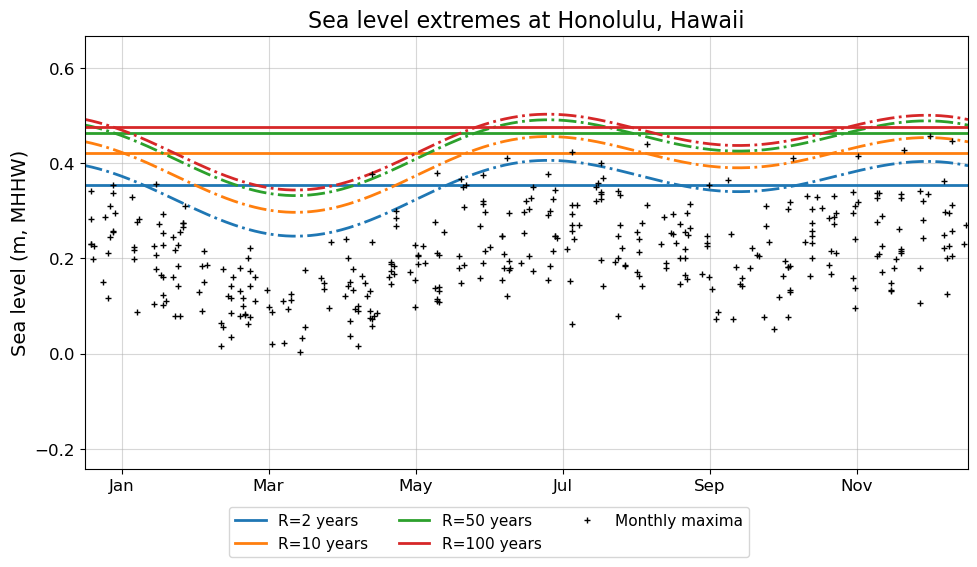

In [20]:
ReturnPeriod = [2,10,50,100]
t = mm['t'].to_numpy()
fig, cmap = plottingExtremeSeasonality(mm['t'],mm['monthly_max'],w_s_plot,ReturnPeriod=ReturnPeriod,SampleRate=12)

# sss.set_xlabel('Month in Year')


plt.title('Sea level extremes at ' + station_name)

# save the figure
savename = 'SeasonalExtremeVariations_'+ ridString +'.png'
savedir = os.path.join(output_dir, savename)
plt.savefig(savedir, dpi=250, bbox_inches='tight')

glue("seasonal_extreme_variations", fig, display=False)

```{glue:figure} seasonal_extreme_variations
:name: "seasonal_extreme_variations"
A climatology of extreme sea levels at the {glue:text}`station_name` tide gauge. Monthly maxima (+), determined from hourly sea level data, are shown from 1993-2023. The solid line corresponds to projected sea level return levels at 2,10,50 and 100 years, using this 30-year chunk of data. This line uses a nonstationary GEV to take the seasonal variations of sea level into account. The 2, 10, 50 and 100-year return levels are shown to vary throughout the year (dashed line), with the lowest extremes occuring in March, and highest extremes peaking in July. No long-term trend is used in this model, and the scale and location parameters are held constant.
```

### Check if we should include a long-term trend (mean sea level rise) in our location parameter
I mean, it's probably statistically significant, but hey, we should test just in case. First, we'll make a function to save our modeled return levels.

In [21]:
def save_model_to_netcdf(x,w,t,covariate,mio,ReturnPeriod,modelName,ridString,savepath, station_name,year0):

    years, RL, RL_high, RL_low = getTimeDependentReturnValue(t, covariate, w,x, ReturnPeriod)
    
    # save the time-dependent return values to a netcdf file
    df = pd.DataFrame(RL, index=ReturnPeriod, columns=years[:-1]+year0)
    df.index.name = 'ReturnPeriod'
    df.columns.name = 'Year'

    df_low = pd.DataFrame(RL_low, index=ReturnPeriod, columns=years[:-1]+year0)
    df_low.index.name = 'ReturnPeriod'
    df_low.columns.name = 'Year'

    df_high = pd.DataFrame(RL_high, index=ReturnPeriod, columns=years[:-1]+year0)
    df_high.index.name = 'ReturnPeriod'
    df_high.columns.name = 'Year'

    ds = xr.Dataset({'ReturnLevel': (['ReturnPeriod', 'Year'], df),
                     'RL_low': (['ReturnPeriod', 'Year'], df_low),
                     'RL_high': (['ReturnPeriod', 'Year'], df_high)})

    # set attributes
    ds.attrs['description'] = 'Time-dependent return values for the GEV model with seasonality, trend, covariate in location and scale, and nodal cycle in location. The x attribute is the binary array of parameters used in the model, where the first 3 elements are the seasonal parameters, the 4th element is the long-term trend, the 5th element is the covariate in location, the 6th element is the covariate in scale, and the 7th element is the nodal cycle.'
    ds.attrs['station_name'] = station_name
    ds.attrs['datum'] = 'STND'
    ds.attrs['model_parameters'] = adjust_w_for_plotting(x,w)
    ds.attrs['model_standard_error'] = standard_error.tolist()
    ds.attrs['record_id'] = ridString
    ds.attrs['units'] = 'm'
    ds.attrs['model'] = modelName
    ds.attrs['x'] = x.tolist()

    # make year a coordinate
    ds = ds.assign_coords(Year=years[:-1]+year0)

    # make ReturnPeriod a coordinate
    ds = ds.assign_coords(ReturnPeriod=ReturnPeriod)

    ds.to_netcdf(savepath)
    print('Model saved to netcdf file at: ', savepath)
    return ds

In [22]:
from scipy.stats import chi2

x_T = np.concatenate((x_s, [1, 0, 0]))  # Long-term Trend


if os.path.exists(model_output_dir / ridString / 'trend_params.json') and runWithoutModel:
    with open(model_output_dir / ridString / 'trend_params.json', 'r') as f:
        output = json.load(f)
        w_T = np.array(output['w'])
        mio = np.array(output['mio'])
        standard_error = np.array(output['standard_error'])
else:
    f_T = fitness(x_T, modelType='GEV_S_T_Cv')
    w_T = np.loadtxt('best.txt', dtype=float)
    mio = np.loadtxt('mio.txt',dtype=float)

    # Assess standard errors of the parameters
    if np.linalg.det(mio) != 0:
        J = np.linalg.inv(mio)
        standard_error = np.sqrt(np.diag(J))
    else:
        print('Model did not finish! Setting standard errors to 0.')
        standard_error = np.zeros_like(np.diag(mio))

# stdError = getLocationError(x_T, t, t, covariate, w_T, mio)
### FIX THIS

aux = np.loadtxt('limits.txt')
# check to see if within limits
wT = w_T[1:]
for j in range(1, len(wT)):
    if wT[j] == aux[j, 0] or wT[j] == aux[j, 1]:
        raise ValueError(f'Trend Run: Parameter #{j} is at the limit: {wT[j]}')

# check significance of adding the trend
diffe = w_T[0] - w_s[0]
p = 1
SignifTrend = chi2.cdf(2 * diffe, p)

print(f'Statistical Significance of Linear Trend: {SignifTrend*100:.2f}%')
print(f'Estimated Trend on monthly Maxima values is: {w_T[1]*w_T[-1]*1000:.2f} mm/year')
print(f'x_T is: {x_T}')
print(f'x_T is: {x_T}')
print(f'w_T is: {w_T}')

output = {'w': w_T.tolist(), 'mio': mio.tolist(), 'standard_error': standard_error.tolist(), 'x': x_T.tolist()}
savepath = os.path.join(model_output_dir,ridString, 'trend_params.json')
with open(savepath, 'w') as f:
    json.dump(output, f)

savepath = os.path.join(model_output_dir,ridString, 'RL_muT.nc')
# save_model_to_netcdf(x,w,t,covariate,standard_error,ReturnPeriod,modelName,ridString,savepath, station_name,year0):

if os.path.exists(savepath):
    print('Model already saved to netcdf file.')
else:
    ds = save_model_to_netcdf(x_T,w_T,t=t,covariate=covariate,standard_error = standard_error,ReturnPeriod=ReturnPeriod,modelName='Model_GEV_S_T_Cv.exe',ridString=ridString,savepath=savepath, station_name=station_name,year0=year0)


Statistical Significance of Linear Trend: 100.00%
Estimated Trend on monthly Maxima values is: 2.97 mm/year
x_T is: [1 1 0 1 0 0]
x_T is: [1 1 0 1 0 0]
w_T is: [ 4.67039758e+02  1.85962112e+00  6.66646400e-02 -2.22472000e-01
 -4.22099000e-03 -4.67291700e-02  5.26789800e-02 -6.08231000e-03
  1.59690000e-03]
Model already saved to netcdf file.


#### Check the covariate in the location parameter.
Let's check if the covariate inclusion in the location parameter is statistically significant.

In [23]:
if SignifTrend > 0.95:
    x_cvte1 = np.concatenate((x_s, [1, 1, 0]))  # Covariate
    wcomp = w_T.copy()
else:
    x_cvte1 = np.concatenate((x_s, [0, 1, 0]))
    wcomp = w_s.copy()

if os.path.exists(model_output_dir / ridString / 'cvte_location_params.json') and runWithoutModel:
    with open(model_output_dir / ridString / 'cvte_location_params.json', 'r') as f:
        output = json.load(f)
        w_cvte1 = np.array(output['w'])
        mio = np.array(output['mio'])
        standard_error = np.array(output['standard_error'])
else:
    f_cvte1 = fitness(x_cvte1, modelType='GEV_S_T_Cv')
    w_cvte1 = np.loadtxt('best.txt', dtype=float)
    mio = np.loadtxt('mio.txt',dtype=float)

    # Assess standard errors of the parameters
    if np.linalg.det(mio) != 0:
        J = np.linalg.inv(mio)
        standard_error = np.sqrt(np.diag(J))
    else:
        print('Model did not finish! Setting standard errors to 0.')
        standard_error = np.zeros_like(np.diag(mio))

diffe = w_cvte1[0] - wcomp[0]
p = 1
SignifCvte1 = chi2.cdf(2 * diffe, p)
print(f'Statistical Significance of Covariate in location param.: {SignifCvte1*100:.2f}%')
print(f'x_cvte1 is: {x_cvte1}')

output = {'w': w_cvte1.tolist(), 'mio': mio.tolist(), 'standard_error': standard_error.tolist(), 'x': x_cvte1.tolist()}
savepath = os.path.join(model_output_dir,ridString, 'cvte_location_params.json')
with open(savepath, 'w') as f:
    json.dump(output, f)

savepath = os.path.join(model_output_dir,ridString, 'RL_muT_cv1.nc')

if os.path.exists(savepath):
    print('Model already saved to netcdf file.')
else:
    ds = save_model_to_netcdf(x_cvte1,w_cvte1,t,covariate,standard_error = standard_error,ReturnPeriod=ReturnPeriod,modelName='Model_GEV_S_T_Cv.exe',ridString=ridString,savepath=savepath, station_name=station_name,year0=year0)

Statistical Significance of Covariate in location param.: 54.60%
x_cvte1 is: [1 1 0 1 1 0]
Model already saved to netcdf file.


### Check the covariate in scale parameter
Let's check if the covariate inclusion in the scale parameter is statistically significant.

In [24]:
if SignifCvte1 > 0.95:
    x_cvte2 = np.concatenate((x_cvte1[:-1], [1]))  # Covariate
    wcomp = w_cvte1.copy()
else:
    x_cvte2 = np.concatenate((x_cvte1[:-2], [0, 1]))  # Covariate
    wcomp = wcomp.copy()

if os.path.exists(model_output_dir / ridString / 'cvte_scale_params.json') and runWithoutModel:
    with open(model_output_dir / ridString / 'cvte_scale_params.json', 'r') as f:
        output = json.load(f)
        w_cvte2 = np.array(output['w'])
        mio = np.array(output['mio'])
        standard_error = np.array(output['standard_error'])
else:
    f_cvte2 = fitness(x_cvte2, modelType='GEV_S_T_Cv')
    w_cvte2 = np.loadtxt('best.txt', dtype=float)
    mio = np.loadtxt('mio.txt', dtype=float)

    # Assess standard errors of the parameters
    if np.linalg.det(mio) != 0:
        J = np.linalg.inv(mio)
        standard_error = np.sqrt(np.diag(J))
    else:
        print('Model did not finish! Setting standard errors to 0.')
        standard_error = np.zeros_like(np.diag(mio))

diffe = w_cvte2[0] - wcomp[0]
p = 1
SignifCvte2 = chi2.cdf(2 * diffe, p)


print(f'Statistical Significance of Covariate in scale param.: {SignifCvte2*100:.2f}%')
print(f'x_cvte2 is: {x_cvte2}')

output = {'w': w_cvte2.tolist(), 'mio': mio.tolist(), 'standard_error': standard_error.tolist(), 'x': x_cvte2.tolist()}
savepath = os.path.join(model_output_dir,ridString, 'cvte_scale_params.json')
with open(savepath, 'w') as f:
    json.dump(output, f)

savepath = os.path.join(model_output_dir,ridString, 'RL_muT_cv2.nc')

# If savepath is not None, save the model to a netcdf file

if os.path.exists(savepath):
    print('Model already saved to netcdf file.')
else:
    ds = save_model_to_netcdf(x_cvte2,w_cvte2,t,covariate,standard_error,ReturnPeriod,modelName='Model_GEV_S_T_Cv.exe',ridString=ridString,savepath=savepath, station_name=station_name,year0=year0)   


Statistical Significance of Covariate in scale param.: 40.86%
x_cvte2 is: [1 1 0 1 0 1]
Model already saved to netcdf file.


### Check the nodal cycle in Location parameter
We will only include the nodal cycle in our final model if adding it significantly improves our model thus far. We will add it to the long-term trend model if the long-term trend is significant.

In [25]:
if SignifCvte2>0.95:
    # x_N=np.append(x_T , [1])
    x_N = np.append(x_cvte2, [1])
    wcomp=w_cvte2.copy()
    print('The trend is significant! \nInclude long-term trend and nodal cycle in final model.')
else:
    # x_N=np.append(x_s,[0, 0, 0, 1])
    x_N = np.append(x_cvte2[:-1], [0,1])
    wcomp=wcomp.copy()

# Check if the results are already saved
if os.path.exists(model_output_dir / ridString / 'nodal_params.json') and runWithoutModel:
    with open(model_output_dir / ridString / 'nodal_params.json', 'r') as f:
        output = json.load(f)
        w_N = np.array(output['w'])
        mioN = np.array(output['mio'])
        standard_error = np.array(output['standard_error'])
        x_N = np.array(output['x'])
else:
    print('Running Nodal cycle model...')
    f_N = fitness(x_N, modelType='GEV_S_T_Cv_Nodal')
    print(f'x_N is: {x_N}')
    w_N = np.loadtxt('best.txt', dtype=float)
    mio = np.loadtxt('mio.txt')
        # Assess standard errors of the parameters
    if np.linalg.det(mio) != 0:
        J = np.linalg.inv(mio)
        standard_error = np.sqrt(np.diag(J))
    else:
        print('Model did not finish! Setting standard errors to 0.')
        standard_error = np.zeros_like(np.diag(mio))


wN = w_N[1:]
for j in range(1, len(wN)):
    if wN[j] == aux[j, 0] or wN[j] == aux[j, 1]:
        raise ValueError(f'Nodal Run: Parameter #{j} is at the limit: {wN[j]}')
    

diffe = w_N[0] - wcomp[0]
p = 2
SignifN = chi2.cdf(2 * diffe, p)

print(f'Statistical Significance of adding Nodal cycle: {SignifN*100:.2f}%')

if SignifN<0.95:
    x_N[-1] = 0 # set the nodal component to zero
    w_N = wcomp.copy() # use the previous model
    w_N = np.append(w_N, [0, 0]) # add zeros for the nodal cycle
    print('Nodal cycle is not significant! \nUse previous model without nodal cycle.\n New x_N is: ', x_N)



# save w_N, mioN, standard_error, x_N as json file
output = {'w': w_N.tolist(), 'mio': mio.tolist(), 'standard_error': standard_error.tolist(), 'x': x_N.tolist()}
savepath = os.path.join(model_output_dir,ridString, 'nodal_params.json')
with open(savepath, 'w') as f:
    json.dump(output, f)

savepath = os.path.join(model_output_dir,ridString, 'RL_muN.nc')


if os.path.exists(savepath) and runWithoutModel:
    print('Model exists: ', savepath)
else:
    ds = save_model_to_netcdf(x_N,w_N,t,covariate,standard_error,ReturnPeriod,modelName='Model_GEV_S_T_Cv_N.exe',ridString=ridString,savepath=savepath, station_name=station_name,year0=year0)


Statistical Significance of adding Nodal cycle: 99.88%
Model exists:  ../../data/GEV_model_output/57/RL_muN.nc


Get a list of the parameter names that correspond to the 'x_N' variable.

In [26]:
param_names = ['Annual seasonal cycle',
    'Semiannual seasonal cycle',
    'Triannual seasonal cycle',
    'Long-term Trend in Location',
    'Covariate in Location',
    'Covariate in Scale',
    'Nodal Cycle']

# Write out the parameter names, where if x[i] = 1, the parameter is included, otherwise it is removed from the list
parameters_included = [param for i, param in zip(x_N, param_names) if i == 1]


# Format the parameter names for display, where each parameter is separated by a comma and the last parameter is preceded by 'and'
parameters_included = ', '.join(parameters_included[:-1]) + ', and ' + parameters_included[-1]
glue("parameters_included", parameters_included)


'Annual seasonal cycle, Semiannual seasonal cycle, Long-term Trend in Location, and Nodal Cycle'

## Plot the timeseries
We'll first extract all the relevant return levels for various models.

```{margin}
```{warning}
Still toying with this!
```

### Plot it up
For now we'll use only the nodal + long-term trend + seasonality model.

1993.0

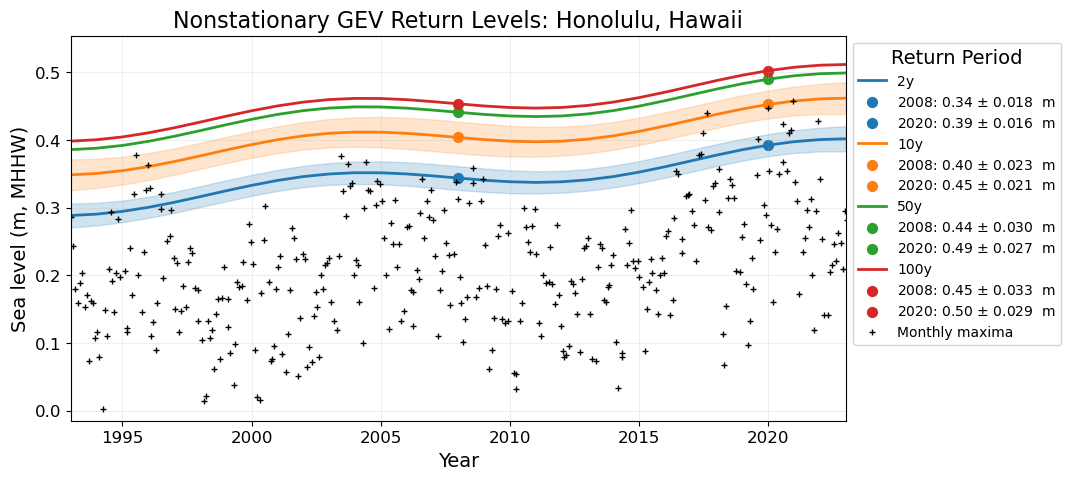

In [27]:
ds = xr.open_dataset(os.path.join(model_output_dir,ridString, 'RL_muN.nc'))
dsMHHW = ds - STNDtoMHHW
dsMHHW.attrs['units'] = 'm, MHHW'

# close the dataset
ds.close()

# get the first year of ds
year0 = dsMHHW['Year'][0].item()

glue("year0", year0)

year0plot = 1993

fig = plt.figure(figsize=(10,5))
sss = fig.add_subplot(1, 1, 1)

yearseval = [2008,2020]

for i, rp in enumerate(dsMHHW['ReturnPeriod']):
    plt.plot(dsMHHW['Year'], dsMHHW['ReturnLevel'][i], color=cmap[i], linewidth=2, label=f'{rp.values}y')
    for year in yearseval:
        yrval = dsMHHW['ReturnLevel'][i].sel(Year = year).values
        std = dsMHHW['RL_high'][i].sel(Year = year).values - yrval
        plt.scatter(year, yrval, color=cmap[i], s=50, label=f'{year}: {yrval:.2f} $\pm$ {std:.3f}  m')
    
plt.fill_between(dsMHHW['Year'], dsMHHW['RL_low'][0], dsMHHW['RL_high'][0], color=cmap[0], alpha=0.2)
plt.fill_between(dsMHHW['Year'], dsMHHW['RL_low'][1], dsMHHW['RL_high'][1], color=cmap[1], alpha=0.2)

# add monthly maxima
plt.plot(mm['t']+year0, mm['monthly_max']-STNDtoMHHW, '+k', markersize=5, label='Monthly maxima',alpha=1)    

# add title of station name
plt.title('Nonstationary GEV Return Levels: ' + station_name)
plt.xlabel('Year')
plt.ylabel('Sea level (m, MHHW)')
plt.grid(True,alpha=0.2)

plt.legend(title='Return Period', loc='upper left', bbox_to_anchor=(1, 1),fontsize=10)

# arrange yaxis for breathing room
meanmaxSL = np.nanmean(mm['monthly_max']-STNDtoMHHW)
rangemaxSL = np.nanmax(mm['monthly_max']) - np.nanmin(mm['monthly_max']) # Range

plt.axis([year0plot, 2023, meanmaxSL-0.5*rangemaxSL, meanmaxSL+0.75*rangemaxSL])

# save the figure
savename = 'TimeDependentReturnValue_'+ ridString +'.png'
savedir = os.path.join(output_dir, savename)
plt.savefig(savedir, dpi=300, bbox_inches='tight')

# glue the figure
glue("TimeDependentReturnValue", fig, display=False)


```{glue:figure} TimeDependentReturnValue
:name: "TimeDependentReturnValue"
Time series of the nonstationary GEV-based extreme water level return values for {glue:text}`station_name`. The monthly maxima (+) are displayed spanning data from {glue:text}`year0` to 2023. The return levels (at 2, 10, 50, and 100 year levels) are shown in solid lines. The 95% Confidence Interval (shaded area) also varies in time, and is shown only for the 2 and 10 year return levels. Years 2008 and 2020 are highlighted on these curves to show the differences in values when taking seasonality, a long-term trend, and the 18.6 nodal-cycle into account. This particular best-fit model for {glue:text}`station_name` includes the {glue:text}`parameters_included`.
```
```{margin}
Caution: Confidence Intervals still getting tweaked!!
```

In [28]:
####INPROGRESS#####


import seaborn as sns
import matplotlib.colors as mcolors
import numpy as np
import plotly.graph_objects as go
import xarray as xr
import os

# Load the dataset
ds = xr.open_dataset(os.path.join(model_output_dir, ridString, 'RL_muN.nc'))
dsMHHW = ds - STNDtoMHHW
dsMHHW.attrs['units'] = 'm, MHHW'

# Get the first year
year0 = dsMHHW['Year'][0].item()

# Generate the Seaborn color palette and convert to hex
seaborn_palette = sns.color_palette()  # Adjust the palette as needed
cmap = [mcolors.to_hex(color) for color in seaborn_palette]

# Create Plotly figure
fig = go.Figure()

yearseval = [2008, 2020]


# Layout configuration
fig.update_layout(
    title=f'Nonstationary GEV Return Levels: {station_name}',
    xaxis_title='Year',
    yaxis_title='Sea level (m, MHHW)',
    yaxis=dict(showline=True,linecolor='black',mirror=True,tickformat='.1f',range=[meanmaxSL - 0.5 * rangemaxSL, meanmaxSL + 0.75 * rangemaxSL]),
    xaxis=dict(showline=True,linecolor='black',mirror=True,tickformat='.0f',range=[year0plot, 2023]),
    legend_title='Return Period',
    legend=dict(
        x=1.1,  # Position the legend horizontally
        y=1,  # Position the legend at the top
    ),    
    template='plotly_white',
    width = 900,
    height = 600
)

# Plot each return period
for i, rp in enumerate(dsMHHW['ReturnPeriod']):
    fig.add_trace(go.Scatter(
        x=dsMHHW['Year'].values,
        y=dsMHHW['ReturnLevel'][i].values,
        mode='lines',
        line=dict(color=cmap[i], width=2),
        name=f'{rp.values}y',
        hovertemplate='%{x:.0f}: %{y:.3f} m'
    ))
    for year in yearseval:
        yrval = dsMHHW['ReturnLevel'][i].sel(Year=year).values
        std = dsMHHW['RL_high'][i].sel(Year=year).values - yrval
        fig.add_trace(go.Scatter(
            x=[year],
            y=[yrval],
            mode='markers+text',
            marker=dict(color=cmap[i], size=10),
            hovertemplate='%{x:.0f}: %{y:.3f} m',
            textposition='top right',
            name=f'{year}: {yrval:.2f} ± {std:.3f} m'
        ))

for i in range(2):
    rgba_color = mcolors.to_rgba(cmap[i], alpha=0.2)  # Adjust alpha for transparency
    
    # Convert the RGBA color to Plotly-friendly format
    fillcolor = f'rgba({rgba_color[0]*255}, {rgba_color[1]*255}, {rgba_color[2]*255}, {rgba_color[3]})'
    fillcolor0 = f'rgba({rgba_color[0]*255}, {rgba_color[1]*255}, {rgba_color[2]*255}, 0)'

    # Add fill between RL_high and RL_low using rgba for transparency
    fig.add_trace(go.Scatter(
        x=dsMHHW['Year'].values,
        y=dsMHHW['RL_high'][i].values,
        mode='lines',  # This can be 'none' if you don't want the line, but usually 'lines' is good
        line=dict(color=fillcolor0),  # Hide the line if desired
        fillcolor=fillcolor,  # Custom RGBA color with transparency
        name='Upper Confidence Interval',
        showlegend=False,
        hoverlabel=dict(
            bgcolor=fillcolor,  # Set background color for the hover box
            font_color=cmap[i]  # Set font color to match the color map
        ),
        hovertemplate='%{x:.0f}: %{y:.3f} m'
    ))

    fig.add_trace(go.Scatter(
        x=dsMHHW['Year'].values,
        y=dsMHHW['RL_low'][i].values,
        mode='lines',  # Again, this can be 'none' if you don't want a line drawn
        fill='tonexty',  # This tells Plotly to fill to the previous trace
        fillcolor=fillcolor,  # Same fillcolor for consistency
        line=dict(color=fillcolor0),  # Hide the line if desired
        showlegend=False,
        name = 'Lower Confidence Interval',
        hoverlabel=dict(
            bgcolor=fillcolor,  # Set background color for the hover box
            font_color=cmap[i]  # Set font color to match the color map
        ),
        hovertemplate='%{x:.0f}: %{y:.3f} m'
    ))





# Assuming `mm` is defined
fig.add_trace(go.Scatter(
    x=mm['t'].values + year0,
    y=mm['monthly_max'].values - STNDtoMHHW,
    mode='markers',
    marker=dict(color='black', size=5, symbol='cross'),
    name='Monthly maxima',
    hovertemplate='%{x:.0f}: %{y:.3f} m'
))

# Save the figure
savename = f'TimeDependentReturnValue_{ridString}.html'


# Optional: Display the figure
fig.show()
#save html
matrix_dir = Path('../../matrix/plotly')
fig.write_html(matrix_dir / savename, full_html=True)


## Create a combined dataset for further plotting and analysis

In [29]:
# One dataset to rule them all

# Find all RL_muN.nc files
file_pattern = str(model_output_dir / '**/RL_muN.nc')
file_paths = glob.glob(file_pattern, recursive=True)

# Initialize an empty list to hold each dataset
datasets = []

for file_path in file_paths:
    ds = xr.open_dataset(file_path)
    
    # Extract important attributes
    record_id = int(ds.attrs.get('record_id'))    
    station_name = ds.attrs.get('station_name')
    x = ds.attrs.get('x')  # Assuming x is stored as an attribute and has varying lengths
    
    # Ensure 'year' and 'return_level' are coordinates and are preserved
    year = ds['year'] if 'year' in ds else ds.coords.get('year')
    return_level = ds['return_level'] if 'return_level' in ds else ds.coords.get('return_level')
    
    # Expand the dataset with the 'station' dimension (coordinate)
    ds = ds.expand_dims({'record_id': [record_id]})
    
    # Store x as a variable with its own dimension (e.g., 'x_dim')
    ds['x'] = xr.DataArray(x, dims=['x_dim'])
    
    # Keep station_name as an attribute of the dataset
    ds.attrs['station_name'] = station_name
    
    # Add the dataset to the list
    datasets.append(ds)

# Combine all datasets along the 'station' dimension
try:
    combined_ds = xr.concat(datasets, dim='record_id', combine_attrs='override')
    print("Combined dataset created successfully.")
except Exception as e:
    print(f"An error occurred during dataset concatenation: {e}")

# remove attributes that are not needed
attributes_to_remove = ['station_name', 'model_parameters', 'model_standard_error', 'model', 'x', 'record_id']
for attr in attributes_to_remove:
    combined_ds.attrs.pop(attr, None)

Combined dataset created successfully.


In [30]:
# add lat, lon, and station_name to the dataset from rsl_hourly
rids = combined_ds['record_id'].values
lats = []
lons = []
MHHW = []
for rid in rids:
    lat = rsl_hourly.sel(record_id=rid)['lat'].values
    lon = rsl_hourly.sel(record_id=rid)['lon'].values
    mhhw = 0.001*rsl_hourly.sel(record_id=rid)['MHHW'].values
    lats.append(lat)
    lons.append(lon)
    MHHW.append(mhhw)

combined_ds['lat'] = xr.DataArray(lats, dims='record_id')
combined_ds['lon'] = xr.DataArray(lons, dims='record_id')
combined_ds['MHHW'] = xr.DataArray(MHHW, dims='record_id')

# add station_name
station_names = rsl_hourly.sel(record_id=rids)['station_name'].values
combined_ds['station_name'] = xr.DataArray(station_names, dims='record_id')

# save the combined dataset to a netcdf file
# combined_ds.to_netcdf(output_dir / 'combined_return_levels.nc')
combined_ds


<xarray.Dataset> Size: 25kB
Dimensions:       (record_id: 8, ReturnPeriod: 4, Year: 31, x_dim: 7)
Coordinates:
  * record_id     (record_id) int64 64B 61 59 50 57 58 60 552 52
  * Year          (Year) float64 248B 1.993e+03 1.994e+03 ... 2.023e+03
  * ReturnPeriod  (ReturnPeriod) int64 32B 2 10 50 100
Dimensions without coordinates: x_dim
Data variables:
    ReturnLevel   (record_id, ReturnPeriod, Year) float64 8kB 1.826 ... 1.833
    RL_low        (record_id, ReturnPeriod, Year) float64 8kB 1.779 ... 1.738
    RL_high       (record_id, ReturnPeriod, Year) float64 8kB 1.873 ... 1.928
    x             (record_id, x_dim) int64 448B 1 1 0 1 0 0 1 ... 1 0 1 0 0 0 1
    lat           (record_id) float32 32B 21.43 20.9 28.22 ... 19.73 20.03 16.75
    lon           (record_id) float32 32B 202.2 203.5 182.6 ... 204.2 190.5
    MHHW          (record_id) float64 64B 1.533 1.364 1.204 ... 1.406 1.225
    station_name  (record_id) <U17 544B 'Mokuoloe' 'Kahului' ... 'Johnston'
Attributes:
    description:  Time-dependent return values for the GEV model with seasona...
    datum:        STND
    units:        m

## Create a Map

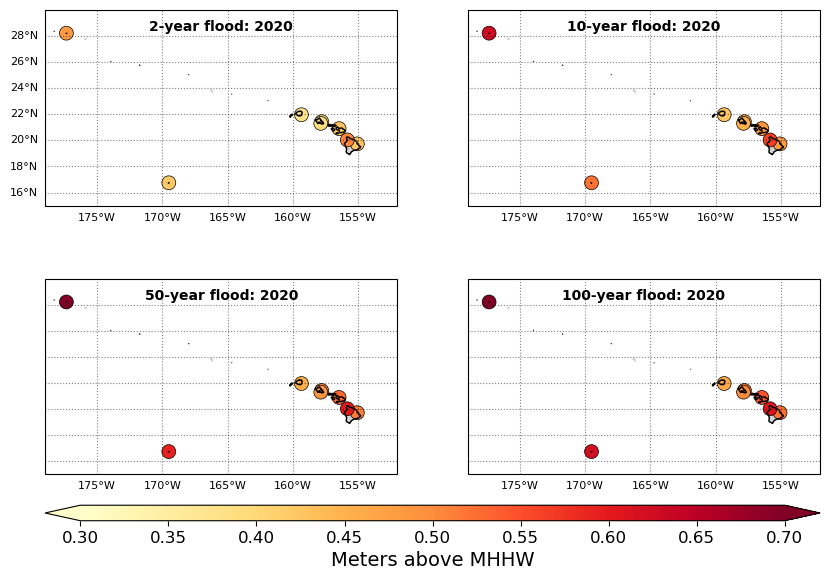

In [31]:
crs = ccrs.PlateCarree()
fig, axs = plt.subplots(2,2,figsize=(10, 8), subplot_kw={'projection': crs})
# make ax,fig
# open the cmems data

xlims = [-179, -152]
ylims = [15, 30]

scatters = []

# plt.colorbar(maxplt,ax=axs[0],label='Sea Level (m)', location='bottom')           

for i, ax in enumerate(axs.flat):

    scatter = ax.scatter(combined_ds['lon'], combined_ds['lat'], transform=crs, s=100, 
               c=combined_ds['ReturnLevel'].sel(Year=2020)[:,i]-combined_ds['MHHW'], cmap='YlOrRd',
               linewidth=0.5, edgecolor='black')
    scatters.append(scatter)

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, color='lightgrey')

    # set extent
    ax.set_extent([xlims[0], xlims[1], ylims[0], ylims[1]], crs=crs)

    #add grid
    gl = ax.gridlines(draw_labels=False, linestyle=':', color='black',
                      alpha=0.5,xlocs=ax.get_xticks(),ylocs=ax.get_yticks())
    if i>=0:
        gl.bottom_labels = True

    if i==0:
        gl.left_labels = True

    #make all labels tiny
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

    # add text to top left of plot
    ax.text(0.5, 0.95, f'{ReturnPeriod[i]}-year flood: 2020', color='black', fontsize=10, weight='bold',
            transform=ax.transAxes, ha='center', va='top', zorder=10)

# add colorbar to the bottom of the plot which follows vmin, vmax and cmap of the scatter plot
# colorbar should be 
cbar = plt.colorbar(axs[1, 1].collections[0], ax=axs, orientation='horizontal', pad=0.05, aspect=50,extend='both')
cbar.set_label('Meters above MHHW')

# set the limits of the colorbar
for scatter in scatters:
    scatter.set_clim(vmin=0.3, vmax=0.7)


# save the figure
plt.savefig(output_dir / 'TimeDependentReturnValueMap.png', dpi=300, bbox_inches='tight')

glue("TimeDependentReturnValueMap",fig,display=False)

```{glue:figure} TimeDependentReturnValueMap
:name: "TimeDependentReturnValueMap"
Map of the nonstationary GEV-based extreme water level return values for Hawaiian Island region stations. Year 2020 is shown here. Each nonstationary model includes some combination of seasonality, a long-term trend, and the 18.6 nodal-cycle, provided each parameter improves the significance of the GEV fit. No covariates are used for these particular best-fit models.
```

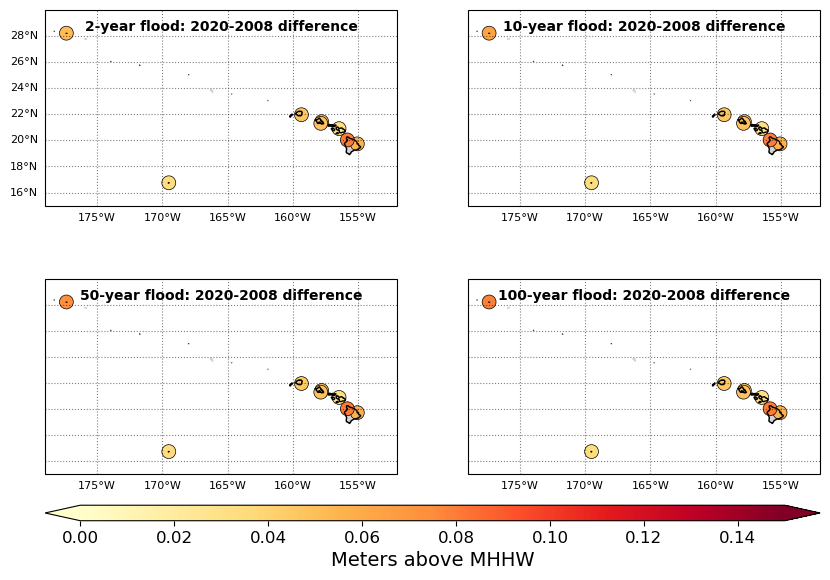

In [32]:
crs = ccrs.PlateCarree()
fig, axs = plt.subplots(2,2,figsize=(10, 8), subplot_kw={'projection': crs})
# make ax,fig
# open the cmems data

xlims = [-179, -152]
ylims = [15, 30]

scatters = []

# plt.colorbar(maxplt,ax=axs[0],label='Sea Level (m)', location='bottom')           

for i, ax in enumerate(axs.flat):

    scatter = ax.scatter(combined_ds['lon'], combined_ds['lat'], transform=crs, s=100, 
               c=combined_ds['ReturnLevel'].sel(Year=2020)[:,i]-combined_ds['ReturnLevel'].sel(Year=2008)[:,i], cmap='YlOrRd',
               linewidth=0.5, edgecolor='black')
    scatters.append(scatter)

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, color='lightgrey')

    # set extent
    ax.set_extent([xlims[0], xlims[1], ylims[0], ylims[1]], crs=crs)

    #add grid
    gl = ax.gridlines(draw_labels=False, linestyle=':', color='black',
                      alpha=0.5,xlocs=ax.get_xticks(),ylocs=ax.get_yticks())
    if i>=0:
        gl.bottom_labels = True

    if i==0:
        gl.left_labels = True

    #make all labels tiny
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

    # add text to top left of plot
    ax.text(0.5, 0.95, f'{ReturnPeriod[i]}-year flood: 2020-2008 difference', color='black', fontsize=10, weight='bold',
            transform=ax.transAxes, ha='center', va='top', zorder=10)

# add colorbar to the bottom of the plot which follows vmin, vmax and cmap of the scatter plot
# colorbar should be 
cbar = plt.colorbar(axs[1, 1].collections[0], ax=axs, orientation='horizontal', pad=0.05, aspect=50,extend='both')
cbar.set_label('Meters above MHHW')

# set the limits of the colorbar
for scatter in scatters:
    scatter.set_clim(vmin=0, vmax=0.15)


# save the figure
plt.savefig(output_dir / 'TimeDependentReturnValueMap2008.png', dpi=300, bbox_inches='tight')

glue("TimeDependentReturnValueMap2008",fig,display=False)